# Topic 25-Pt 2: Intro to Logistic Regression 

- onl01-dtsc-ft-022221
- 05/06/21

## Announcements

- Blog Post Deadline Extended until Monday at 10 AM EST.

## Overview

- For Today:
    - Types of machine learning.
        - Supervised vs Unsupervised Learning
        - Regression vs Classification 
    - From Linear to Logistic Regression - Theory
    - Applying Logistic Regression with `scikit-learn`
        - Proper preprocessing with train-test-split.
    - Evaluating Classifiers
        - Confusion Matrices
        - Accuracy, ~~Precision, Recall, F1-Score~~



- For Next Class:
    - Classification Metrics 
        - Confusion Matrices
        - Accuracy, Precision, Recall, F1-Score
        - ROC-AUC curve
    - Class Imbalance Problems
    - Functionizing evaluating classification models

## Questions?

-  Given that we are not using R^2 in our cost function, what metric are we using in our cost function? Additionally, is gradient descent being used to minimize this cost function? 

# Implementing Logistic Regression

## Predict Passenger Survival on the Titanic with `scikit-learn`

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 


# import statsmodels.api as sm

In [2]:
url = "https://raw.githubusercontent.com/jirvingphd/dsc-dealing-missing-data-lab-online-ds-ft-100719/master/titanic.csv"
df = pd.read_csv(url,index_col=0,na_values='?')
relevant_columns = ['Pclass', 'Age', 'SibSp', 'Fare', 'Sex', 'Embarked', 'Survived']
df = df[relevant_columns]
df.head()

,Pclass,Age,SibSp,Fare,Sex,Embarked,Survived
0,3.0,22.0,1,7.2500,male,S,0
1,1.0,38.0,1,71.2833,female,C,1
2,3.0,26.0,0,7.9250,female,S,1
3,1.0,35.0,1,53.1000,female,S,1
4,3.0,35.0,0,8.0500,male,S,0


In [3]:
df['Survived'].value_counts(normalize=True,dropna=False)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Text(0.5, 0.98, 'X Features vs Survived')

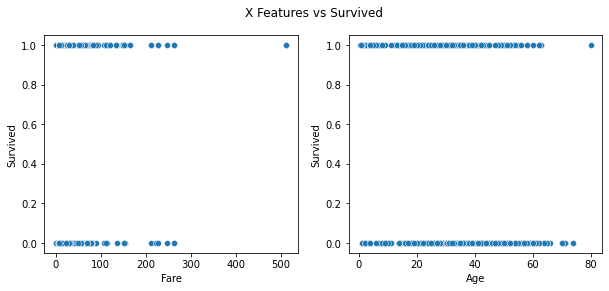

In [4]:
fig,ax= plt.subplots(ncols=2,figsize=(10,4))
sns.scatterplot(data=df, x='Fare',y='Survived',ax=ax[0])
sns.scatterplot(data=df, x='Age',y='Survived',ax=ax[1])
fig.suptitle('X Features vs Survived')

Text(0.5, 0.98, 'X Features vs Survived - Regression')

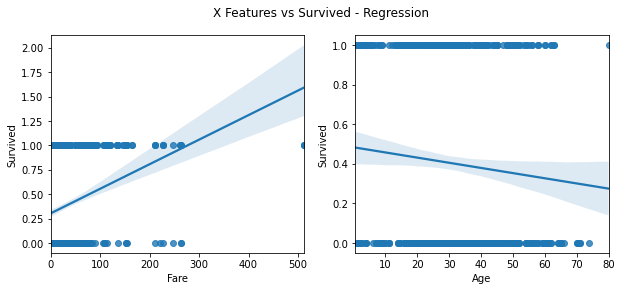

In [5]:
fig,ax= plt.subplots(ncols=2,figsize=(10,4))
sns.regplot(data=df, x='Fare',y='Survived',ax=ax[0])
sns.regplot(data=df, x='Age',y='Survived',ax=ax[1])
fig.suptitle('X Features vs Survived - Regression')

### Q: What are the preprocessing steps I need to perform before I create the model?

- Recast data types
- Train-test-split
- Fill/drop in missing/null values
- Feature Selection / Feature Engineering (interaction terms)
- Handling categorial variables
    - One Hot Encoding 
    - Label Encoding
- Handling Outliers (maybe)
- Normalizing/Standardizing our data

- **Multicollinearity (does it still matter as much for Logistic?)**



In [6]:
## Check out the .info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    842 non-null    float64
 1   Age       714 non-null    float64
 2   SibSp     891 non-null    int64  
 3   Fare      891 non-null    float64
 4   Sex       891 non-null    object 
 5   Embarked  889 non-null    object 
 6   Survived  891 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 55.7+ KB


In [7]:
## Check Object cols value_counts
display(df['Embarked'].value_counts(dropna=False),
        df['Sex'].value_counts(dropna=False))

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

male      577
female    314
Name: Sex, dtype: int64

### Preprocessing

In [8]:
## Separate X and y and train-test-split
target = 'Survived'

y = df[target]
X = df.drop(target, axis=1)

# Perform test train split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,)


In [9]:
## Check for nulls in training set
X_train.isna().sum()

Pclass       38
Age         130
SibSp         0
Fare          0
Sex           0
Embarked      1
dtype: int64

In [10]:
df['Pclass'].value_counts(normalize=True,dropna=False)

3.0    0.526375
1.0    0.225589
2.0    0.193042
NaN    0.054994
Name: Pclass, dtype: float64

In [11]:
df['Embarked'].value_counts(normalize=True,dropna=False)

S      0.722783
C      0.188552
Q      0.086420
NaN    0.002245
Name: Embarked, dtype: float64

In [12]:
pclass_counts = dict(X_train['Pclass'].value_counts(normalize=True))
pclass_counts

{3.0: 0.5538461538461539, 1.0: 0.2376068376068376, 2.0: 0.20854700854700856}

### 🚩Part 2 Update re filling nulls using class balances/prob:

In [13]:
### Filling in from sample distribution is easier than what i was doing yesterday.
p_class = X_train['Pclass'].fillna(np.random.choice(list(pclass_counts.keys()),
                                                  p=list(pclass_counts.values())))
p_class.isna().sum()

0

In [14]:
p_class.value_counts()

3.0    324
1.0    177
2.0    122
Name: Pclass, dtype: int64

#### Original Part 1 Continued

In [15]:
X_train['Pclass'].value_counts(dropna=False)

3.0    324
1.0    139
2.0    122
NaN     38
Name: Pclass, dtype: int64

In [16]:
SimpleImputer()

SimpleImputer()

In [17]:
## Specify which values to impute with which method

## Most frequent
mode_cols =['Pclass','Embarked']
## Fill with median
median_cols = ['Age']


In [18]:
## Copying X_train and X_test as start of X_train_tf,X_test_tf
X_train_tf = X_train.copy()
X_test_tf = X_test.copy()

In [19]:
## Impute the columns with most-frequent value
impute_mode = SimpleImputer(strategy='most_frequent')
X_train_tf[mode_cols] = impute_mode.fit_transform(X_train_tf[mode_cols])
X_test_tf[mode_cols] = impute_mode.transform(X_test_tf[mode_cols])
## Verify it worked
X_train_tf.isna().sum()

Pclass        0
Age         130
SibSp         0
Fare          0
Sex           0
Embarked      0
dtype: int64

In [20]:
## Impute the columns with most-frequent value
impute_median = SimpleImputer(strategy='median')
X_train_tf[median_cols] = impute_median.fit_transform(X_train_tf[median_cols])
X_test_tf[median_cols] = impute_median.transform(X_test_tf[median_cols])
## Verify it worked
X_train_tf.isna().sum(), X_test_tf.isna().sum()

(Pclass      0
 Age         0
 SibSp       0
 Fare        0
 Sex         0
 Embarked    0
 dtype: int64,
 Pclass      0
 Age         0
 SibSp       0
 Fare        0
 Sex         0
 Embarked    0
 dtype: int64)

In [21]:
X_train_tf['Pclass'] = X_train_tf['Pclass'].astype(str)
X_test_tf['Pclass'] = X_test_tf['Pclass'].astype(str)

X_train_tf

,Pclass,Age,SibSp,Fare,Sex,Embarked
713,3.0,29.0,0,9.4833,male,S
167,3.0,45.0,1,27.9000,female,S
728,2.0,25.0,1,26.0000,male,S
619,2.0,26.0,0,10.5000,male,S
883,2.0,28.0,0,10.5000,male,S
...,...,...,...,...,...,...
131,3.0,20.0,0,7.0500,male,S
289,3.0,22.0,0,7.7500,female,Q
596,2.0,29.0,0,33.0000,female,S
118,1.0,24.0,0,247.5208,male,C


In [22]:
## Specifing which cols to encode and which to scale.
#  make cat_cols and num_cols
cat_cols = X_train_tf.select_dtypes('O').columns
num_cols = X_train_tf.select_dtypes('number').columns
num_cols,cat_cols

(Index(['Age', 'SibSp', 'Fare'], dtype='object'),
 Index(['Pclass', 'Sex', 'Embarked'], dtype='object'))

In [23]:
## Encode cat_cols
encoder = OneHotEncoder(sparse=False,drop='first')
train_cat_cols = encoder.fit_transform(X_train_tf[cat_cols])
test_cat_cols = encoder.transform(X_test_tf[cat_cols])
train_cat_cols

array([[0., 1., 1., 0., 1.],
       [0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 1., 0., 1.]])

In [24]:
train_cat_cols = pd.DataFrame(train_cat_cols,columns=encoder.get_feature_names(cat_cols))
test_cat_cols =  pd.DataFrame(test_cat_cols,columns=encoder.get_feature_names(cat_cols))
test_cat_cols

,Pclass_2.0,Pclass_3.0,Sex_male,Embarked_Q,Embarked_S
0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...
263,0.0,1.0,0.0,0.0,1.0
264,0.0,0.0,1.0,0.0,1.0
265,0.0,1.0,1.0,0.0,1.0
266,0.0,1.0,1.0,0.0,0.0


In [25]:
## Scaling Num_cols
scaler = StandardScaler()
train_num_cols = pd.DataFrame(scaler.fit_transform(X_train_tf[num_cols]),
                              columns=num_cols)
test_num_cols =  pd.DataFrame(scaler.transform(X_test_tf[num_cols]),
                              columns=num_cols)
train_num_cols

,Age,SibSp,Fare
0,-0.052795,-0.474993,-0.448189
1,1.150523,0.435532,-0.099131
2,-0.353624,0.435532,-0.135143
3,-0.278417,-0.474993,-0.428920
4,-0.128002,-0.474993,-0.428920
...,...,...,...
618,-0.729661,-0.474993,-0.494309
619,-0.579247,-0.474993,-0.481041
620,-0.052795,-0.474993,-0.002469
621,-0.428832,-0.474993,4.063420


In [26]:
## Combine Num and Cat Cols
X_train_tf = pd.concat([train_num_cols,train_cat_cols],axis=1)
X_test_tf = pd.concat([test_num_cols,test_cat_cols],axis=1)
X_test_tf

,Age,SibSp,Fare,Pclass_2.0,Pclass_3.0,Sex_male,Embarked_Q,Embarked_S
0,1.300938,-0.474993,0.357645,0.0,0.0,1.0,0.0,1.0
1,0.323242,-0.474993,-0.381536,1.0,0.0,1.0,0.0,1.0
2,-0.579247,-0.474993,-0.481041,0.0,1.0,0.0,0.0,1.0
3,0.774486,0.435532,-0.099131,0.0,1.0,1.0,0.0,1.0
4,0.172827,-0.474993,-0.477724,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
263,0.699279,0.435532,-0.035164,0.0,1.0,0.0,0.0,1.0
264,0.924901,0.435532,0.357645,0.0,0.0,1.0,0.0,1.0
265,-1.406528,4.077632,0.260983,0.0,1.0,1.0,0.0,1.0
266,-0.052795,-0.474993,-0.462799,0.0,1.0,1.0,0.0,0.0


In [27]:
X_train_tf.describe().round(2)


,Age,SibSp,Fare,Pclass_2.0,Pclass_3.0,Sex_male,Embarked_Q,Embarked_S
count,623.00,623.00,623.00,623.0,623.00,623.00,623.0,623.00
mean,-0.00,0.00,-0.00,0.2,0.58,0.64,0.1,0.72
std,1.00,1.00,1.00,0.4,0.49,0.48,0.3,0.45
min,-2.20,-0.47,-0.63,0.0,0.00,0.00,0.0,0.00
25%,-0.58,-0.47,-0.48,0.0,0.00,0.00,0.0,0.00
50%,-0.05,-0.47,-0.34,0.0,1.00,1.00,0.0,1.00
75%,0.40,0.44,-0.04,0.0,1.00,1.00,0.0,1.00
max,3.78,6.81,9.08,1.0,1.00,1.00,1.0,1.00


## Fitting a Logistic Regression with `scikit-learn`

In [28]:
## Fit a logistic regression model with defaults
log_reg = LogisticRegression(C=1e12)
log_reg.fit(X_train_tf,y_train)

LogisticRegression(C=1000000000000.0)

In [29]:
## Get the model's .score for training and test set 
print(f"Training Score:\t{log_reg.score(X_train_tf,y_train):.2f}")
print(f"Test Score:\t{log_reg.score(X_test_tf,y_test):.2f}")

Training Score:	0.79
Test Score:	0.82


In [30]:
### Getting our model's coefficients
## Our function from last class
def get_coefficients(model,X_train):
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns)
    coeffs['intercept'] = model.intercept_[0]
    return coeffs

## get the model's coefficients
get_coefficients(log_reg,X_train_tf)

Age          -0.385058
SibSp        -0.436739
Fare          0.262769
Pclass_2.0   -0.555462
Pclass_3.0   -1.272990
Sex_male     -2.541014
Embarked_Q   -0.167323
Embarked_S   -0.224023
intercept     2.127684
dtype: float64

In [31]:
## Get Predictions for training and test data to check metrics functions
y_hat_train = log_reg.predict(X_train_tf)
y_hat_test = log_reg.predict(X_test_tf)

In [32]:
## Try accuracy_score
metrics.accuracy_score(y_train,y_hat_train)

0.7865168539325843

### How do I know if my accuracy score is good?

> Does your model predict better than chance/just getting the class distribution?
- Compare your accuracy to your normalized value counts for y
- Compare your model against a `DummyClassifier` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

In [33]:
## Check the class balance for the y_train
y_train.value_counts(normalize=True)

0    0.603531
1    0.396469
Name: Survived, dtype: float64

In [34]:
## Check the class balance for y_test
y_test.value_counts(normalize=True)

0    0.645522
1    0.354478
Name: Survived, dtype: float64

In [35]:
from sklearn.dummy import DummyClassifier
## Make and fit  dummy classifier
model = DummyClassifier(strategy='stratified')
model.fit(X_train_tf,y_train)
model.score(X_test_tf,y_test)

0.5261194029850746

In [36]:
## Get the model's .score
print(f"Training Score:\t{model.score(X_train_tf,y_train):.2f}")
print(f"Test Score:\t{model.score(X_test_tf,y_test):.2f}")

Training Score:	0.52
Test Score:	0.53


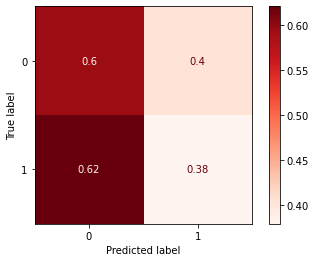

In [37]:
## Check the confusion matrix
metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap='Reds',normalize='true')

> But accuracy isn't the best metric when you have imbalanced classes. 
- Next class we will introduce more classification metrics

## 🚩Revisiting Question from Part 1: Interpreting LogisticRegresion Coefficients

### Resources:


- [Central Lecturer Logistic Regression Notebook (cited below)]( https://nbviewer.jupyter.org/github/flatiron-school/ds-logistic_regression/blob/main/logistic_regression.ipynb)
- [Medium Blog Post on Interpreting Linear Regression and Logistic Regression Coefficients](https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1)

### From [Central Lecturer `logistic_regression.ipynb` Notebook )]( https://nbviewer.jupyter.org/github/flatiron-school/ds-logistic_regression/blob/main/logistic_regression.ipynb):<br>

The **sigmoid function**. <br/>
$$\large\hat{y} = \Large\frac{1}{1 + e^{-\hat{L}}} \large= \Large\frac{1}{1 + e^{-(\beta_0 + ... + \beta_nx_n)}}$$ 


- How do we fit a line to our dependent variable if its values are already stored as probabilities? 
    - We can ***use the inverse of the sigmoid function, and just set our regression equation equal to that.*** 
    - The inverse of the sigmoid function is called the **logit function**, and it looks like this:

$$\large f(y) = \ln\left(\frac{y}{1 - y}\right)$$
- Notice that the domain of this function is $(0, 1)$.

### From the [Medium Blog Post on Interpreting Linear Regression and Logistic Regression Coefficients](https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1)

>"Because of the logit function, logistic regression coefficients represent the log odds that an observation is in the target class (“1”) given the values of its X variables. Thus, these log odd coefficients need to be converted to regular odds in order to make sense of them. Happily, this is done by simply exponentiating the log odds coefficients, which you can do with np.exp()"<br>- [Blog Post](https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1)

In [38]:
coeffs = get_coefficients(log_reg,X_train_tf)
coeffs

Age          -0.385058
SibSp        -0.436739
Fare          0.262769
Pclass_2.0   -0.555462
Pclass_3.0   -1.272990
Sex_male     -2.541014
Embarked_Q   -0.167323
Embarked_S   -0.224023
intercept     2.127684
dtype: float64

In [39]:
## Odds are how much more likely to fall into 1 class than 0 class
coeffs_odds = np.exp(coeffs)
coeffs_odds

Age           0.680411
SibSp         0.646140
Fare          1.300526
Pclass_2.0    0.573807
Pclass_3.0    0.279993
Sex_male      0.078787
Embarked_Q    0.845927
Embarked_S    0.799297
intercept     8.395405
dtype: float64

#### Interpreting Odds Coefficients
> ***“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) (when all other variables are held constant).”***

- For "Age"=0.66: 
    - For every 1 sd increase in Age, the odds that the person Survived (class=1) are 0.66 x as large as the odds the person died. 
- For Fare = 1.5:
    - For every increase of 1sd in Fare the odds the person Survived are 1.5 times the odds that they diedd. 
- For Sex_male=0.09
    - The odds that a male survives is 0.09 times greater than the odds they died.
- For Females (1-Sex_male) = .91
    - The odds that a female survived is .91 times greater than the odds they died. 

#### Converting to Probability


$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$

And so the logit function represents the **log-odds** of success (y=1).

In [40]:
coeffs_prob = coeffs_odds/(1+coeffs_odds)
coeffs_prob

Age           0.404908
SibSp         0.392518
Fare          0.565317
Pclass_2.0    0.364598
Pclass_3.0    0.218746
Sex_male      0.073033
Embarked_Q    0.458267
Embarked_S    0.444227
intercept     0.893565
dtype: float64

In [41]:
## update function to return 
def get_coefficients(model,X_train,units = "log-odds"):
    """Returns model coefficients. 
    
    Args:
        model: sklearn model with the .coef_ attribute. 
        X_train: dataframe with the feature names as the .columns
        units (str): Can be ['log-odds','odds','prob']
        """
    options = ['log-odds','odds','prob']
    
    if units not in options:
        raise Exception(f'units must be one of {options}')
        
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns)
    coeffs['intercept'] = model.intercept_[0]
    
    if units=='odds':
        coeffs = np.exp(coeffs)
        
    elif units=='prob':
        coeffs = np.exp(coeffs)
        coeffs = coeffs/(1+coeffs)
        

    coeffs.name=units
    return coeffs

In [42]:
coeffs_odds = get_coefficients(log_reg,X_train_tf,units='odds')
coeffs_odds

Age           0.680411
SibSp         0.646140
Fare          1.300526
Pclass_2.0    0.573807
Pclass_3.0    0.279993
Sex_male      0.078787
Embarked_Q    0.845927
Embarked_S    0.799297
intercept     8.395405
Name: odds, dtype: float64

# Part 2: Evaluating Classifiers, Dealing with Class Imbalance, and `GridSearchCV`

- 05/07/21

## Confusion Matrices: Understanding Our Model's Mistakes

- For classification tasks, it can be extremely helpful to examine a "Confusion Matrix" to understand how our model is wrong. 

In [43]:
## Use metrics.confusion_matrix
metrics.confusion_matrix(y_test,y_hat_test)

array([[151,  22],
       [ 27,  68]])

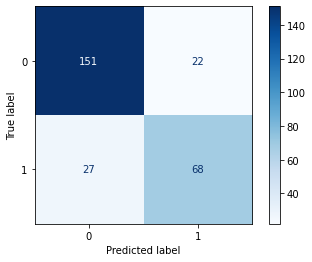

In [44]:
## Use metrics.plot_confusion_matrix
metrics.plot_confusion_matrix(log_reg, X_test_tf,y_test,cmap='Blues')#,
#                              display_labels=["Died",'Survived'])

>- The Confusion Matrix separated out the correct (true) predictions for the positive class (1) and negative class (0). 
```
[TN,FP],
[FN,TP]
```
- **_True Positives (TP)_**: The number of observations where the model predicted the person has the disease (1), and they actually do have the disease (1).

- **_True Negatives (TN)_**: The number of observations where the model predicted the person is healthy (0), and they are actually healthy (0).

- **_False Positives (FP)_**: The number of observations where the model predicted the person has the disease (1), but they are actually healthy (0). 

- **_False Negatives (FN)_**: The number of observations where the model predicted the person is healthy (0), but they actually have the disease (1).


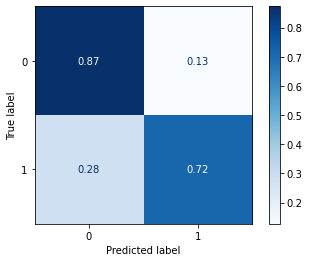

In [45]:
metrics.plot_confusion_matrix(log_reg, X_test_tf,y_test,cmap='Blues',normalize='true')#,

## Evaluation Metrics

> [The 5 Classification Evaluation metrics every Data Scientist must know](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)

- **Classification Metrics are based on the confusion matrices of our model**

```
[TN,FP],
[FN,TP]
```

In [46]:
## Remake the conf matrix (raw counts)
cm = metrics.confusion_matrix(y_test,y_hat_test)
cm

array([[151,  22],
       [ 27,  68]])

In [47]:
## SLice out TN/FP/etc from cm
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]

In [48]:
## Make sure we got the order right
print(TN,FP)
print(FN,TP)

151 22
27 68


### Accuracy

$$ \large \text{Accuracy} = \frac{\text{Number of True Positives + True Negatives}}{\text{Total Observations}} $$

> "Out of all the predictions our model made, what percentage were correct?"
- "Accuracy is the most common metric for classification. It provides a solid holistic view of the overall performance of our 
model."

#### When to use?
- **Accuracy** is good for non-technical audiences (but can be misleading with imbalanced classes)


In [49]:
## calcualte accuracy manually
acc = (TP+TN)/(TP+TN+FP+FN)
acc

0.8171641791044776

In [50]:
## compare against the accuracy_score
metrics.accuracy_score(y_test,y_hat_test)

0.8171641791044776

### Precision

> "**_Precision_** measures what proportion of predicted Positives is truly Positive?


$$ \large \text{Precision} = \frac{\text{Number of True Positives}}{\text{Number of Predicted Positives}} $$


#### When to use?
- **Use precision** when the cost of acting is high and acting on a positive is costly.
   - e.g. Allocating resources/interventions for prisoners who are at-risk for recidivism. 

In [51]:
metrics.precision_score(y_test, y_hat_test)

0.7555555555555555

In [52]:
prec = TP/(FP+TP)
prec

0.7555555555555555

### Recall (AKA Sensitivity)

> **_Recall_** indicates what percentage of the classes we're interested in were actually captured by the model."
$$ \large \text{Recall} = \frac{\text{Number of True Positives}}{\text{Number of Actual Total Positives}} $$ 


#### When to use?
- **Use recall** when the number of true positives/opportunities is small and you don’t want to miss one.
    - e.g. cancer diagnosis. (telling someone they do not have cancer when they actually do is fatal)

In [53]:
metrics.recall_score(y_test, y_hat_test)

0.7157894736842105

In [54]:
rec = TP /(TP+FN)
rec

0.7157894736842105

#### Sensitivity vs Specificity
- Sensitivity(True Positive rate) measures the proportion of positives that are correctly identified
- Specificity (True Negative rate) measures the proportion of negatives that are correctly identified


> Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

In [55]:
print(metrics.classification_report(y_test,y_hat_test))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       173
           1       0.76      0.72      0.74        95

    accuracy                           0.82       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268



In [56]:
## for binary classification, can get Specifity from 0 class's recall.
report = metrics.classification_report(y_test,y_hat_test,output_dict=True)
sensitivty = report['1']['recall']
specificity = report['0']['recall']

In [57]:
sensitivty

0.7157894736842105

In [58]:
specificity

0.8728323699421965

<!-- <img src='https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/precisionrecall.png' width=50%> -->

### $F_1$ Score

F1 score represents the **_Harmonic Mean of Precision and Recall_**.  In short, this means that the F1 score cannot be high without both precision and recall also being high. When a model's F1 score is high, you know that your model is doing well all around. 

> Harmonic Mean: "the reciprocal of the arithmetic mean of the reciprocals of a given set of observatins." - *[Wikipedia](https://en.wikipedia.org/wiki/Harmonic_mean)*

#### Arithmetic Mean:

$$\large \bar{X} = \frac{a+b+c}{n} $$

#### Harmonic Mean:

$$ \large \bar{X} = \frac{n}{\frac{1}{a}+ \frac{1}{b}+ \frac{1}{c}}$$


**The formula for F1 score is:**

> $$ \text{F1 score} =  \frac{2}{\text{Precision}^{-1}\ x\ \text{Recall}^{-1}}= 2\ \frac{\text{Precision}\ x\ \text{Recall}}{\text{Precision} + \text{Recall}} $$

#### When to use?
- **F1 score** is really the most informative about overall model quality.
- BUT is the most difficult to express to a non-tech audience

In [59]:
f1_score = 2*prec*rec / (prec + rec)
print(f1_score)

0.7351351351351352


In [60]:
metrics.f1_score(y_test,y_hat_test)

0.7351351351351352

## Which metric to use?

- **When in doubt, use them all!** 
 -`metrics.classification_report`
 

- **But some good rules of thumb:**
    - **Accuracy** is good for non-technical audiences (but can be misleading with imbalanced classes)
    
    - **Use recall** when the number of true positives/opportunities is small and you don’t want to miss one.
        - e.g. cancer diagnosis. (telling someone they do not have cancer when they actually do is fatal)
    - **Use precision** when the cost of acting is high and acting on a positive is costly.
       - e.g. Allocating resources/interventions for prisoners who are at-risk for recidivism. 

- **F1 score** is really the most informative about overall model quality, but is the most difficult to express to a non-tech audience

In [61]:
print(metrics.classification_report(y_test,y_hat_test,target_names=['Died','Survived']))

              precision    recall  f1-score   support

        Died       0.85      0.87      0.86       173
    Survived       0.76      0.72      0.74        95

    accuracy                           0.82       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268



# ROC Curve - Receiver Operating Characteristic Curve

### Graph Interpretation

- ROC Curves plot the True Positive Rate (TPR) vs the False Positive Rate(FPR)

    - TPR = TP / (TP+FN)
    - FPR = FP / (FP+TN)
    
- The higher the area under the roc curve is another metric we can use to evaluate our model.

In [62]:
## Calc TPR and FPR
TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TPR,FPR

(0.7157894736842105, 0.12716763005780346)

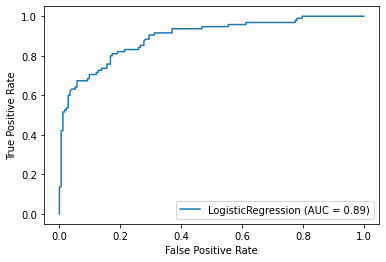

In [63]:
metrics.plot_roc_curve(log_reg,X_test_tf,y_test)

- False Positive Rate vs True Positive Rate → for each threshold

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/roc_comparison.png" width=70%>

In [64]:
## We can use the AUC to judge how good the model is  (higher AUC the better)
# but it needs something new: y_score.
# metrics.roc_auc_score()

In [65]:
## Get y_score or y_score_prob from the log_reg decision function / predict proba
y_score = log_reg.decision_function(X_test_tf)
y_score_prob = log_reg.predict_proba(X_test_tf)[:,1]

In [66]:
# Scikit-learn's built in roc_curve method returns the fpr, tpr, and threshold
# for various decision boundaries given the case member probabilites

fpr,tpr,thresh = metrics.roc_curve(y_test,y_score)
display(fpr[:5],tpr[:5],thresh[:5])

array([0., 0., 0., 0., 0.])

array([0.        , 0.01052632, 0.07368421, 0.09473684, 0.13684211])

array([4.02040745, 3.02040745, 2.68167434, 2.68039551, 2.51280737])

In [67]:
## we can get the auc from y_test and y_score
roc_auc = metrics.roc_auc_score(y_test,y_score)
roc_auc

0.894371767569212

In [68]:
## Can also calc from fpr,tpr
metrics.auc(fpr,tpr)

0.894371767569212

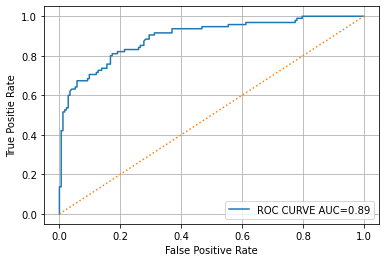

In [69]:
## Plot The ROC Curve
fig, ax = plt.subplots(nrows=1,figsize=(6,4))

# ax =axes[0]
## PLot fpt vs tpr
ax.plot(fpr,tpr, label=f'ROC CURVE AUC={round(metrics.auc(fpr, tpr),2)}')

## Plot a diagnonal line to indicate worthless model
ax.plot([0,1],[0,1],ls=':',)

## Properly Label axes and title figure
ax.set(xlabel='False Positive Rate',ylabel='True Positie Rate')
## Add legend and grid

ax.legend()
ax.grid()


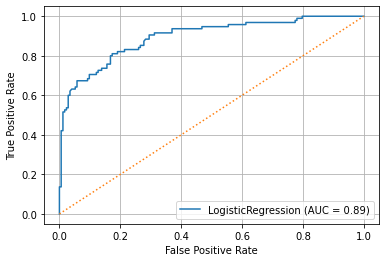

In [70]:
curve = metrics.plot_roc_curve(log_reg,X_test_tf,y_test)
ax = curve.ax_
fig = ax.get_figure()

ax.legend()
ax.plot([0,1],[0,1],ls=':')
ax.grid()

# Activity: Make an `evaluate_classification` function

- Write a function called `evaluate_classification`
- It should accept (at minimum): 
    - model (sklearn model)
    - X_test
    - y_test
    
- ***Ideally you should also accept X_train and y_train to compare results to check for overfitting. ?***
- It should produce:
    - Classification metrics printed
    - Confusion Matrix displayed
    - roc_auc curve displayed
    
    
- Then revisit some of the questions we had from last class re: scaling, LogisticRegression parameters

In [71]:
import sklearn.metrics as metrics

def evaluate_classification(model,X_test,y_test,classes=None,
                           normalize='true',cmap="Blues",figsize=(10,5),
                           return_fig=False): 
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    ## Classification Report / Scores 
    dashes = '---'*20
    print(dashes)
    print("[i] CLASSIFICATION REPORT")
    print(dashes)
    
    print(metrics.classification_report(y_test,y_hat_test,
                                        target_names=classes))
    print(dashes)
    
    fig, axes = plt.subplots(ncols=2, 
                             figsize=figsize)
    
    ## Confusion Matrix
    metrics.plot_confusion_matrix(model, X_test,
                                  y_test,normalize=normalize,
                                  display_labels=classes,
                                 cmap=cmap,ax=axes[0])
    ## Plot ROC Curve
    metrics.plot_roc_curve(model,X_test,y_test,ax=axes[1])

    ax = axes[1]
    ax.legend()
    ax.plot([0,1],[0,1],ls=':')
    ax.grid()
    
    if return_fig:
        return fig,axes
    
    
    

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

        Died       0.85      0.87      0.86       173
    Survived       0.76      0.72      0.74        95

    accuracy                           0.82       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268

------------------------------------------------------------


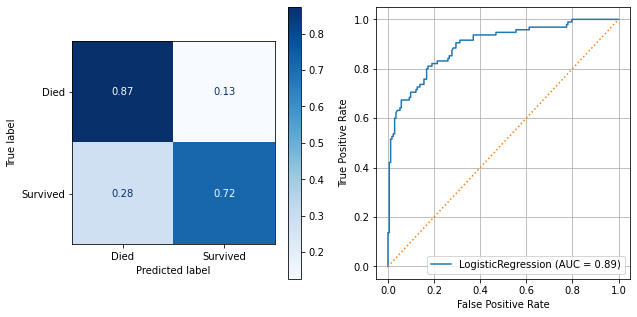

In [72]:
## Fit and evaluate a logistic regression 
params  = dict(C=1e5, solver='liblinear')
log_reg = LogisticRegression(**params)
log_reg.fit(X_train_tf, y_train)

evaluate_classification(log_reg,X_test_tf,y_test,
                        classes=['Died','Survived']);#,label=str(params));

# How to select the best values for our LogisticRegression's hyperparameters

## Hyperparameter Tuning: GridSearchCV 

- C = regularization strenght (inverse)
- penalty: 'l1','l2','elasticnet'
- solver: (see below)
#### `solver` Parameter
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

- The solvers implemented in the class LogisticRegression are “liblinear”, “newton-cg”, “lbfgs”, “sag” and “saga”:

- The solver “liblinear” uses a coordinate descent (CD) algorithm, and relies on the excellent C++ LIBLINEAR library, which is shipped with scikit-learn. However, the CD algorithm implemented in liblinear cannot learn a true multinomial (multiclass) model; instead, the optimization problem is decomposed in a “one-vs-rest” fashion so separate binary classifiers are trained for all classes. This happens under the hood, so LogisticRegression instances using this solver behave as multiclass classifiers.





In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [75]:
model = LogisticRegression()
params= {'C':[0.001, 0.01, 0.1, 1, 10, 100,1e6,1e12],
        'penalty':['l1','l2','elastic_net'],
        'solver':["liblinear", "newton-cg", "lbfgs", "sag","saga"],}
gridsearch = GridSearchCV(model, params)##,scoring='roc_auc')
gridsearch

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000000.0,
                               1000000000000.0],
                         'penalty': ['l1', 'l2', 'elastic_net'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']})

In [76]:
gridsearch.fit(X_train_tf, y_train)
best_params = gridsearch.best_params_
best_params

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

In [77]:
gridsearch.best_estimator_

LogisticRegression(C=1, penalty='l1', solver='liblinear')

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       173
           1       0.76      0.72      0.74        95

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.82      0.82      0.82       268

------------------------------------------------------------


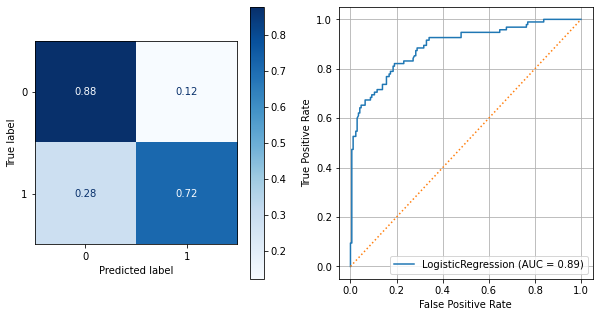

In [78]:
best_model = gridsearch.best_estimator_
evaluate_classification(best_model,X_test_tf,y_test)

### What about if we wanted better recall?


> All named scoring options in sklearn:
    - https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

In [79]:
###  scoring='recall'
model = LogisticRegression()
params= {'C':[0.001, 0.01, 0.1, 1, 10, 100,1e6,1e12],
        'penalty':['l1','l2','elastic_net']}
gridsearch = GridSearchCV(model, params,scoring='recall')
gridsearch.fit(X_train_tf,y_train)
gridsearch.best_params_

{'C': 10, 'penalty': 'l2'}

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       173
           1       0.76      0.72      0.74        95

    accuracy                           0.82       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268

------------------------------------------------------------


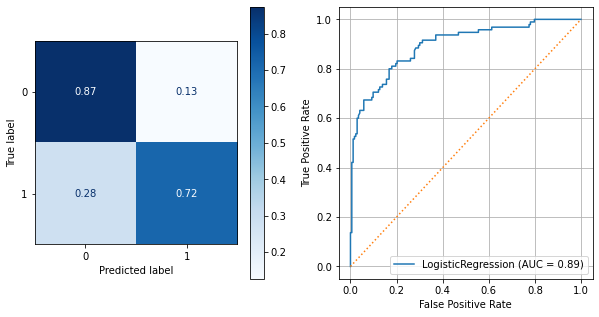

In [80]:
best_model = gridsearch.best_estimator_#LogisticRegression(**best_params)
evaluate_classification(best_model,X_test_tf,y_test)

In [81]:
# ## additional details in cv_results_
# res_df = pd.DataFrame(gridsearch.cv_results_)
# res_df

In [82]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
model = LogisticRegression()

params = {'C' : [0.01,0.1,1.0,10,100,1e5],
          'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
          'solver':["liblinear", "newton-cg", "lbfgs", "sag","saga"],
          'fit_intercept':[True,False],
          'class_weight':[None,'balanced']
         }

gridsearch = GridSearchCV(model,params,scoring='roc_auc',return_train_score=True)
gridsearch.fit(X_train_tf,y_train)

print('BEST RESULTS:')
print(gridsearch.best_score_)
gridsearch.best_params_

BEST RESULTS:
0.8228394844253492


{'C': 1.0,
 'class_weight': None,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'saga'}

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       173
           1       0.76      0.72      0.74        95

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.82      0.82      0.82       268

------------------------------------------------------------


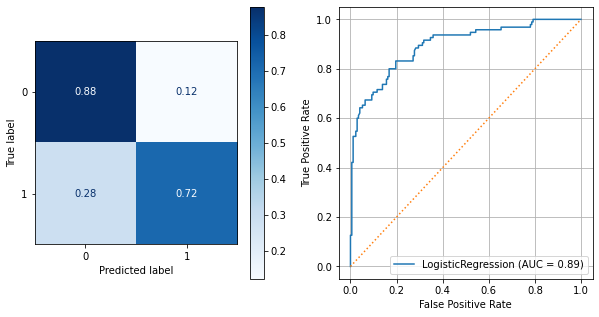

In [83]:
best_model =gridsearch.best_estimator_# LogisticRegression(**best_params)

evaluate_classification(best_model,X_test_tf,y_test)

In [84]:
# grid_results = pd.DataFrame(gridsearch.cv_results_)
# grid_results.sort_values('mean_train_score')

# Class Imbalance

## Class Imbalance Problems Lab

In [87]:
df = pd.read_csv('../creditcard.csv.gz')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [88]:
target = 'Class'
y = df[target].copy()
X = df.drop(columns=target).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

y_train.value_counts(1)

0    0.998258
1    0.001742
Name: Class, dtype: float64

### When metrics can be misleading...
- i.e. accuracy


In [89]:
# from sklearn
params = dict(fit_intercept=False,C=1e12, solver='liblinear')
regr = LogisticRegression(**params)#fit_intercept=False,C=1e12, solver='liblinear')
regr.fit(X_train, y_train)

regr.score(X_test,y_test)

0.9984691441251651

> ### Woohoo! We must have an amazing model!!...

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.54      0.56      0.55       120

    accuracy                           1.00     71202
   macro avg       0.77      0.78      0.78     71202
weighted avg       1.00      1.00      1.00     71202

------------------------------------------------------------


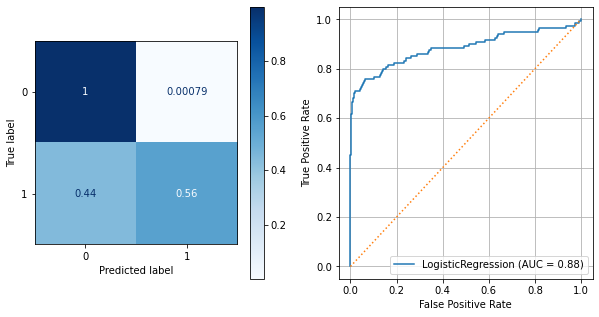

In [90]:
evaluate_classification(regr,X_test, y_test)#,label='Imbalanced');

In [91]:
y_test.value_counts(normalize=True)

0    0.998315
1    0.001685
Name: Class, dtype: float64

### DummyClassifier for Dummies

In [92]:
from sklearn.dummy import DummyClassifier

## Let's guess 0 for every observation
dummy = DummyClassifier(strategy='constant',constant=0)

preds = dummy.fit(X_train,y_train).predict(X_test)

## How did we do?
dummy.score(X_test,y_test)

0.9983146540827504

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.00      0.00      0.00       120

    accuracy                           1.00     71202
   macro avg       0.50      0.50      0.50     71202
weighted avg       1.00      1.00      1.00     71202

------------------------------------------------------------


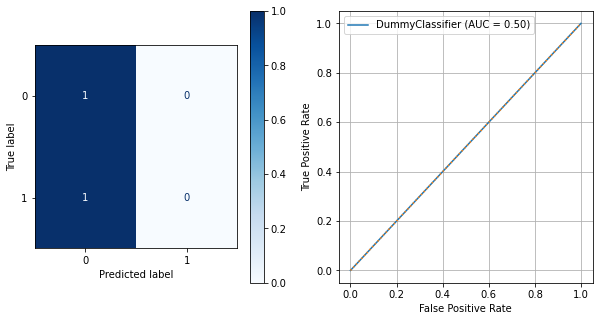

In [93]:
evaluate_classification(dummy,X_test, y_test)#,label='Dummy');

> So what can we do?

## Options for Dealing with Class Imbalance

- Using `class_weight` parameter 
- Oversampling the minority class
- Undersampling the majority class

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.54      0.56      0.55       120

    accuracy                           1.00     71202
   macro avg       0.77      0.78      0.78     71202
weighted avg       1.00      1.00      1.00     71202

------------------------------------------------------------
{'fit_intercept': False, 'C': 1000000000000.0, 'solver': 'liblinear'}


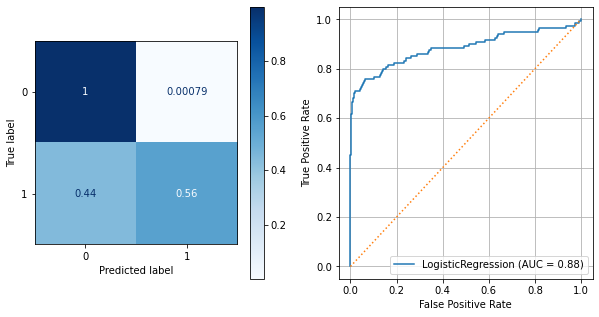

In [94]:
## Baseline Model using lesson paras
regr = LogisticRegression(**params)
regr.fit(X_train, y_train)
evaluate_classification(regr,X_test,y_test)#,label="BASELINE" )
print(params)#str(params))

### Solution 1: `class_weight="balanced"`


------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71082
           1       0.05      0.91      0.09       120

    accuracy                           0.97     71202
   macro avg       0.52      0.94      0.54     71202
weighted avg       1.00      0.97      0.98     71202

------------------------------------------------------------


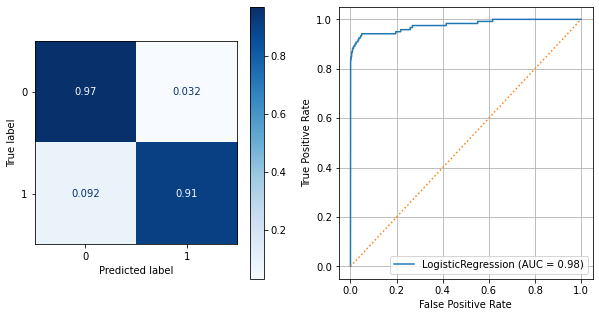

In [95]:
regr = LogisticRegression(class_weight='balanced',**params)
regr.fit(X_train, y_train)
evaluate_classification(regr,X_test,y_test)#,label='balanced')

### Solution 2: Oversampling minority class with SMOTE

In [96]:
y_train.value_counts(0)

0    213233
1       372
Name: Class, dtype: int64

In [97]:
# !pip install -U imblearn
from imblearn.over_sampling import SMOTE,SMOTENC

In [98]:
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_sample(X_train,y_train)
pd.Series(y_train_smote).value_counts()

1    213233
0    213233
Name: Class, dtype: int64

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71082
           1       0.07      0.88      0.14       120

    accuracy                           0.98     71202
   macro avg       0.54      0.93      0.56     71202
weighted avg       1.00      0.98      0.99     71202

------------------------------------------------------------


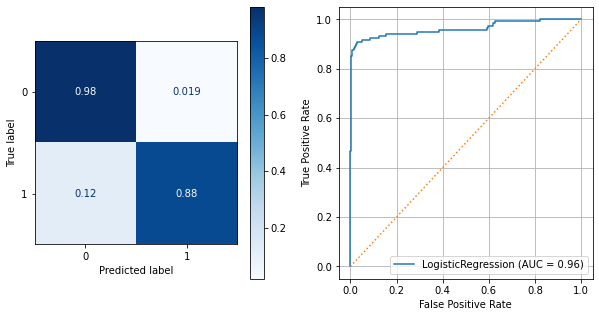

In [99]:
regr = LogisticRegression(**params)#class_weight='balanced',C=1e5, solver='liblinear')
regr.fit(X_train_smote, y_train_smote)
evaluate_classification(regr,X_test,y_test)#,label='SMOTE')

### Solution 3: Undersampling majority class

In [100]:
df_balance = pd.concat([X_train, y_train],axis=1)
df_balance

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
194763,130747.0,2.047163,0.107987,-1.806515,0.072733,0.248371,-1.744837,0.712448,-0.488842,-0.102709,...,0.241017,0.822618,0.023000,0.549868,0.322173,0.191755,-0.085025,-0.084292,0.77,0
135660,81344.0,1.282404,0.459864,-0.372286,0.826375,0.463568,-0.466407,0.460867,-0.186469,-0.549700,...,0.013986,0.083896,-0.247504,-0.325527,0.927293,-0.272555,-0.010168,-0.005332,1.79,0
259186,159004.0,-0.414863,0.012026,1.356386,1.107374,0.813456,-0.156497,-0.372675,0.031095,-0.100143,...,-0.052272,-0.088160,0.062521,-0.680805,-0.641474,-0.159995,0.237628,0.204343,5.95,0
87387,61662.0,-1.432948,1.478076,0.576724,0.207540,-0.670662,-0.464572,0.221023,-0.099811,1.561896,...,-0.055014,0.364330,0.154670,0.635611,-0.366314,0.163690,-0.750285,-0.275117,9.20,0
267282,162703.0,2.051016,-0.016765,-2.284865,0.302168,0.786895,-0.998558,0.768990,-0.464383,0.362863,...,0.133331,0.491780,-0.119020,0.527179,0.607105,-0.090453,-0.065787,-0.062680,47.53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211543,138459.0,-1.321976,1.138686,-0.940861,0.154160,0.109802,-0.538822,0.490058,0.513762,-0.493834,...,-0.012778,-0.237503,0.008713,-0.767844,-0.397162,0.316379,-0.463125,-0.010589,49.89,0
86293,61167.0,-0.627810,0.918729,1.478453,0.213171,0.933695,1.261486,0.504752,0.404286,-0.939740,...,-0.051356,-0.004245,0.090535,-0.964599,-0.522294,0.296733,0.145939,0.110400,24.99,0
122579,76616.0,1.512602,-0.949435,-0.219062,-1.638850,-0.856348,-0.465996,-0.669193,-0.135566,-2.284345,...,-0.558803,-1.377240,0.080444,-0.579511,0.297851,-0.495367,-0.001415,0.003665,34.90,0
152315,97253.0,1.798863,-1.699791,-0.142182,-0.619533,-1.570248,0.083268,-1.501980,0.176287,1.755507,...,0.181914,0.351358,0.115638,-0.566188,-0.596200,-0.295152,-0.033616,-0.032471,171.31,0


In [101]:
n_samples = df_balance['Class'].value_counts().min()
n_samples

372

In [102]:
df_balance.groupby('Class').groups.keys()

dict_keys([0, 1])

In [103]:
df_resample = pd.DataFrame()
for grp,idx in df_balance.groupby('Class').groups.items():
    
    resample = df_balance.loc[idx].sample(n=n_samples,random_state=123)
    df_resample = pd.concat([df_resample,resample],axis=0)
    
display(df_resample.head(), df_resample["Class"].value_counts())



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
230178,146225.0,-1.471584,1.048034,-0.121530,0.294235,1.008532,6.129592,-3.153504,-1.929004,1.661659,...,4.157237,0.048731,0.680405,0.668165,-1.277351,-0.467549,0.527242,0.278444,1.00,0
247695,153661.0,2.096084,-1.376627,0.194561,-0.715901,-1.553168,0.431772,-1.763065,0.331340,0.865917,...,0.151258,0.704155,0.173941,-0.470474,-0.324661,-0.177678,0.055154,-0.053309,3.20,0
204626,135369.0,1.863445,-0.981573,-0.694210,-0.857710,-0.806651,-0.232154,-0.772867,0.156154,1.461948,...,0.261563,0.644129,0.164242,0.746726,-0.436316,0.651170,-0.064889,-0.045237,80.10,0
13793,24459.0,-0.888568,1.220439,1.253009,0.741607,0.414096,-0.072251,1.186912,-0.623745,1.231374,...,-0.152703,0.387293,-0.174805,-0.045627,-0.214310,-0.434546,-0.184802,-0.165824,61.81,0
244902,152535.0,1.973384,-0.235705,-0.453193,0.238827,-0.313211,-0.236997,-0.408025,-0.007399,0.809414,...,-0.187040,-0.377358,0.318120,-0.426956,-0.378039,-0.662360,0.033402,-0.043114,7.81,0


1    372
0    372
Name: Class, dtype: int64

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     71082
           1       0.04      0.93      0.07       120

    accuracy                           0.96     71202
   macro avg       0.52      0.94      0.53     71202
weighted avg       1.00      0.96      0.98     71202

------------------------------------------------------------


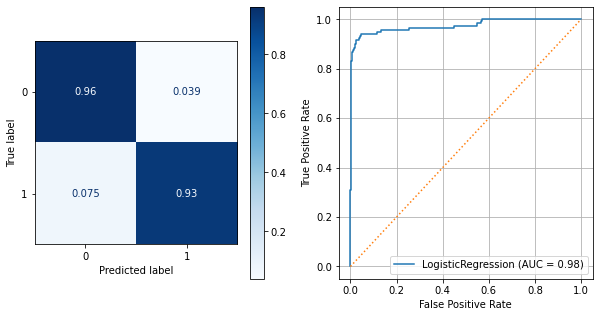

In [104]:
X_train_under = df_resample.drop('Class',axis=1).copy()
y_train_under = df_resample['Class'].copy()

regr = LogisticRegression(**params)#C=1e5, solver='liblinear')
regr.fit(X_train_under, y_train_under)
evaluate_classification(regr,X_test,y_test)

# APPENDIX 

## Additional ROC Curve 

### What Distributions Would Work Well in Classifying?

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/roc_crossover.png" width=60%>

### Defining the Threshold

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/auc_rates.png" width=60%>

In [105]:
# # Interactive ROC curve
# from IPython.display import IFrame
# IFrame('http://www.navan.name/roc/', width=800, height=600)